Defining functions from param.py (Jiayi's github) 

In [14]:
import numpy as np


def modular_uptake(N, M, N_modules, s_ratio):
    assert N_modules <= M and N_modules <= N, "N_modules must be less than or equal to both M and N"

    # Baseline calculations
    sR = M // N_modules
    dR = M - (N_modules * sR)

    sC = N // N_modules
    dC = N - (N_modules * sC)

    # Get module sizes for M
    diffR = np.full(N_modules, sR, dtype=int)
    diffR[np.random.choice(N_modules, dR, replace=False)] += 1
    mR = [list(range(x - 1, y)) for x, y in zip((np.cumsum(diffR) - diffR + 1), np.cumsum(diffR))]

    # Get module sizes for N
    diffC = np.full(N_modules, sC, dtype=int)
    diffC[np.random.choice(N_modules, dC, replace=False)] += 1
    mC = [list(range(x - 1, y)) for x, y in zip((np.cumsum(diffC) - diffC + 1), np.cumsum(diffC))]

    # Preallocate u matrix
    u = np.random.rand(N, M)

    # Apply scaling
    for x, y in zip(mC, mR):
        u[np.ix_(x, y)] *= s_ratio

    # Normalize each row
    for i in range(N):
        u[i, :] /= np.sum(u[i, :])

    return u


def modular_leakage(M, N_modules, s_ratio, λ):
    assert N_modules <= M, "N_modules must be less than or equal to M"

    # Baseline
    sR = M // N_modules
    dR = M - (N_modules * sR)

    # Get module sizes and add to make to M
    diffR = np.full(N_modules, sR, dtype=int)
    diffR[np.random.choice(N_modules, dR, replace=False)] += 1
    mR = [list(range(x - 1, y)) for x, y in zip((np.cumsum(diffR) - diffR + 1), np.cumsum(diffR))]

    l = np.random.rand(M, M)

    for i, x in enumerate(mR):
        for j, y in enumerate(mR):
            if i == j or i + 1 == j:
                l[np.ix_(x, y)] *= s_ratio

    for i in range(M):
        l[i, :] = λ * l[i, :] / np.sum(l[i, :])

    return l


def generate_l_tensor(N, M, N_modules, s_ratio, λ):
    l_tensor = np.array([modular_leakage(M, N_modules, s_ratio, λ) for _ in range(N)])
    return l_tensor

Defining MiCRM 

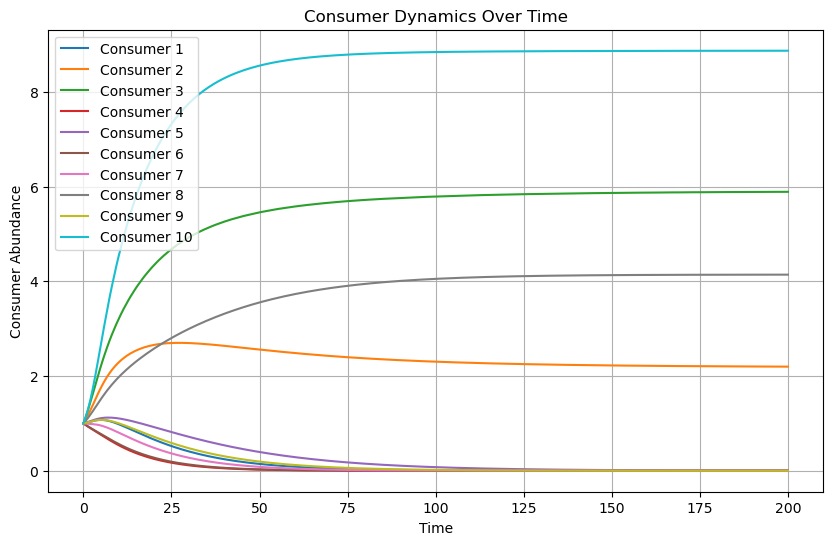

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root


# parameters
N_pool = 1000  # Species pool size
M_pool = 20     # Resource pool size
λ = 0.3        # Total leakage rate
N_modules = 5  # Number of modules of consumer to resource 

s_ratio = 10.0 # Modularity ratio 
# When s_ratio = 1: Resources have a uniform leakage probability；
# When s_ratio > 1: Increases leakage probability within the same module, Increases leakage probability between adjacent modules.

N = 10  # consumer number
M = 5  # resource number
λ_u = np.ones(N)


u_pool = modular_uptake(N_pool, M_pool, N_modules, s_ratio) # this is the uptake matrix for pool
l_pool = generate_l_tensor(N_pool, M_pool, N_modules, s_ratio, λ) # this is leakage tensor for pool (incl uptake matrix elements)


# Set rho and omega for the resource pool
rho_pool = np.full(M_pool, 0.6)
omega_pool = np.full(M_pool, 0.1)
m_pool = np.full(N_pool, 0.1) # mortality rate of N consumers 


# randomly select N and M species from the pool
species_indices1 = np.random.choice(N_pool, N, replace=False) # take random consumers from pool 
resource_indices1 = np.random.choice(M_pool, M, replace=False) # take random resources from pool 

u = u_pool[np.ix_(species_indices1, resource_indices1)] # uptake matrices 
l = l_pool[np.ix_(species_indices1, resource_indices1, resource_indices1)] # leakage tensors 

lambda_alpha1 = np.full(M, λ)

rho = rho_pool[resource_indices1]
omega = omega_pool[resource_indices1]
m = m_pool[species_indices1] 



# ode for MiCRM 
def MiCRM_dCdt_Rdt(t, y): # y is a combined array of state variables, representing both C and Y values at time t 
    C = y[:N] # C gets the first N values 
    R = y[N:] # R gets the remaining M values 
    dCdt = np.zeros(N)
    dRdt = np.zeros(M)
    
    # the last 2 lines here initialise the zero arrays, so dCdt and dRdt eqns can be filled in later 
    
    for i in range(N): # the consumer portion of the equation 
        dCdt[i] = sum(C[i] * R[alpha] * u[i, alpha] * (1 - lambda_alpha[alpha]) for alpha in range(M)) - C[i] * m[i]
        
    
    for alpha in range(M): # the resource portion of the equation 
        dRdt[alpha] = rho[alpha] - R[alpha] * omega[alpha]
        dRdt[alpha] -= sum(C[i] * R[alpha] * u[i, alpha] for i in range(N))
        dRdt[alpha] += sum(sum(C[i] * R[beta] * u[i, beta] * l[i, beta, alpha] for beta in range(M)) for i in range(N))
    
    return np.concatenate([dCdt, dRdt])

# intial value
C0 = np.full(N,1)  # consumer
R0 = np.full(M,1)   # resource
Y0 = np.concatenate([C0, R0])

# time sacle
t_span = (0, 200) 
t_eval = np.linspace(*t_span, 300) 

# solve ode
MiCRM_sol = solve_ivp(MiCRM_dCdt_Rdt, t_span, Y0, t_eval=t_eval)

# plot results 
plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(MiCRM_sol.t, MiCRM_sol.y[i], label=f'Consumer {i+1}') 

plt.xlabel('Time')
plt.ylabel('Consumer Abundance')
plt.title('Consumer Dynamics Over Time')
plt.legend()
plt.grid()
plt.show()




Incorporating ELV into the same model

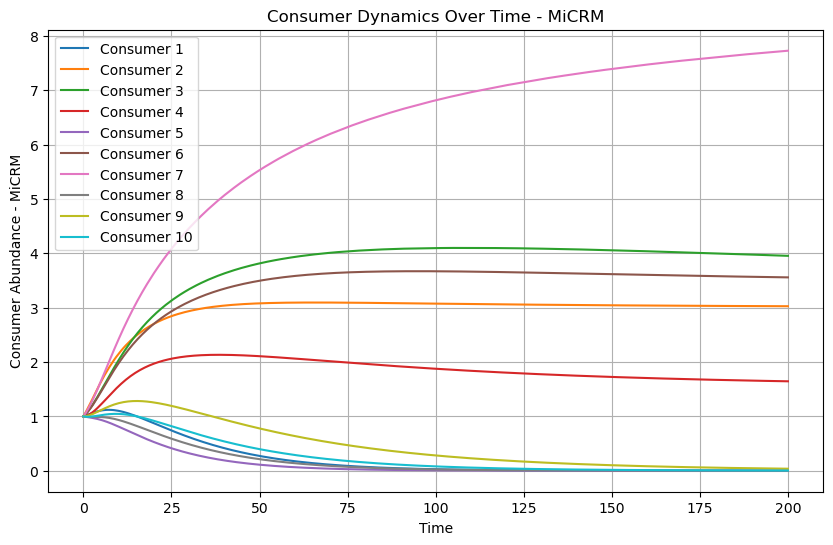

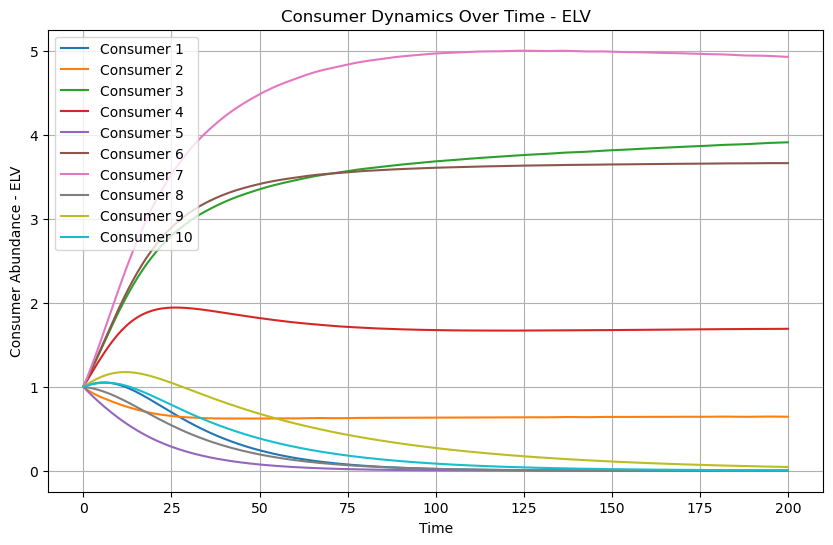

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root


# parameters
N_pool = 1000  # Species pool size
M_pool = 20     # Resource pool size
λ = 0.3        # Total leakage rate
N_modules = 5  # Number of modules of consumer to resource 

s_ratio = 10.0 # Modularity ratio 
# When s_ratio = 1: Resources have a uniform leakage probability；
# When s_ratio > 1: Increases leakage probability within the same module, Increases leakage probability between adjacent modules.

N = 10  # consumer number
M = 5  # resource number
λ_u = np.ones(N)


u_pool = modular_uptake(N_pool, M_pool, N_modules, s_ratio) # this is the uptake matrix for pool
l_pool = generate_l_tensor(N_pool, M_pool, N_modules, s_ratio, λ) # this is leakage tensor for pool (incl uptake matrix elements)


# Set rho and omega for the resource pool
rho_pool = np.full(M_pool, 0.6)
omega_pool = np.full(M_pool, 0.1)
m_pool = np.full(N_pool, 0.1) # mortality rate of N consumers 


# randomly select N and M species from the pool
species_indices1 = np.random.choice(N_pool, N, replace=False) # take random consumers from pool 
resource_indices1 = np.random.choice(M_pool, M, replace=False) # take random resources from pool 

u = u_pool[np.ix_(species_indices1, resource_indices1)] # uptake matrices 
l = l_pool[np.ix_(species_indices1, resource_indices1, resource_indices1)] # leakage tensors 

lambda_alpha = np.full(M, λ)

rho = rho_pool[resource_indices1]
omega = omega_pool[resource_indices1]
m = m_pool[species_indices1] 



# ode for MiCRM 
def MiCRM_dCdt_Rdt(t, y): # y is a combined array of state variables, representing both C and Y values at time t 
    C = y[:N] # C gets the first N values 
    R = y[N:] # R gets the remaining M values 
    dCdt = np.zeros(N)
    dRdt = np.zeros(M)
    
    # the last 2 lines here initialise the zero arrays, so dCdt and dRdt eqns can be filled in later 
    
    for i in range(N): # the consumer portion of the equation 
        dCdt[i] = sum(C[i] * R[alpha] * u[i, alpha] * (1 - lambda_alpha[alpha]) for alpha in range(M)) - C[i] * m[i]
        
    
    for alpha in range(M): # the resource portion of the equation 
        dRdt[alpha] = rho[alpha] - R[alpha] * omega[alpha]
        dRdt[alpha] -= sum(C[i] * R[alpha] * u[i, alpha] for i in range(N))
        dRdt[alpha] += sum(sum(C[i] * R[beta] * u[i, beta] * l[i, beta, alpha] for beta in range(M)) for i in range(N))
    
    return np.concatenate([dCdt, dRdt])

# intial value
C0 = np.full(N,1)  # consumer
R0 = np.full(M,1)   # resource
Y0 = np.concatenate([C0, R0])

# time scale
t_span = (0, 200) 
t_eval = np.linspace(*t_span, 300) 

# solve ode
MiCRM_sol = solve_ivp(MiCRM_dCdt_Rdt, t_span, Y0, t_eval=t_eval)


# ode for ELV 

# Define the steady-state equation
def steady_state_eq(y, n_species, m_resources, u, l, m, lambda_alpha, rho, omega):
    C = y[:n_species]
    R = y[n_species:]
    eq_C = C * (np.sum(R * u * (1 - lambda_alpha), axis=1) - m)
    eq_R = rho - omega * R - np.sum(C[:, np.newaxis] * u * R, axis=0)
    eq_R += np.einsum('i,ib,iba->a', C, u * R, l)
    return np.concatenate([eq_C, eq_R])


# Solve for the steady state of Community 1
C_guess1 = np.full(N, 0.1)
R_guess1 = np.full(M, 1.0)
y_guess1 = np.concatenate([C_guess1, R_guess1])
sol_steady1 = root(lambda y: steady_state_eq(y, N, M, u, l, m, lambda_alpha1, rho, omega), y_guess1)
C_hat1 = sol_steady1.x[:N]
R_hat1 = sol_steady1.x[N:]


# D for Community 1
D1 = np.diag(omega + np.sum(C_hat1[:, np.newaxis] * u, axis=0))
D1 -= np.einsum('i,ig,iag->ag', C_hat1, u * R_hat1, l)


# Calculate ∂R_α/∂C_j
partial_R_C1 = np.zeros((M, N))
for j in range(N):
    v_j = -R_hat1 * u[j] + np.einsum('b,b,ba->a', R_hat1, u[j], l[j])
    partial_R_C1[:, j] = np.linalg.solve(D1, v_j)
    
    
# Calculate α_ij and r_i
alpha1 = np.einsum('ia,a,aj->ij', u, 1 - lambda_alpha1, partial_R_C1)
r1 = np.sum(u * (1 - lambda_alpha1) * R_hat1, axis=1) - m - np.sum(alpha1 * C_hat1, axis=1)


# Define the eLV model for Community 1
def dCdt_elv1(t, C):
    return C * (r1 + alpha1 @ C)

# so this eLV model incorporates time vs consumer abundance (so graph should be similar to MiCRM structure) 
# parameters are just 'r' which is intrinsic growth rate, and 'alpha' which is interaction coefficient
# previously defined r_i and a_ij, derived from MiCRM terms. since effective GLV is derived from MiCRM. 


# Solve the dynamics of Community 1
C0_1 = np.full(N, 1) # initial condition for consumer abundance
t_span = (0, 200)
t_eval = np.linspace(*t_span, 300)
ELV_sol = solve_ivp(dCdt_elv1, t_span, C0_1, t_eval=t_eval)


# plot results for MiCRM and ELV side by side: 

plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(MiCRM_sol.t, MiCRM_sol.y[i], label=f'Consumer {i+1}') 

plt.xlabel('Time')
plt.ylabel('Consumer Abundance - MiCRM')
plt.title('Consumer Dynamics Over Time - MiCRM')
plt.legend()
plt.grid()
plt.show()



plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(ELV_sol.t, ELV_sol.y[i], label=f'Consumer {i+1}') 

plt.xlabel('Time')
plt.ylabel('Consumer Abundance - ELV')
plt.title('Consumer Dynamics Over Time - ELV')
plt.legend()
plt.grid()
plt.show()


